In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

## XOR Learning

As can be seen in the figure below, XOR could be framed as a non-linear binary classification problem. Linear models, such as logistic regression or even single layer neural networks, will not be able to find a solution. We need to introduce nonlinearity by using multiple neural network layers.

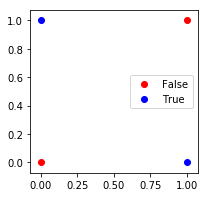

In [2]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(0, 0, c='r', label='False')
ax.scatter(1, 1, c='r')
ax.scatter(1, 0, c='b', label='True')
ax.scatter(0, 1, c='b')
legend = ax.legend(loc='best')
plt.show()

Logistic regression cannot find a solution:

In [3]:
def accuracy_score(true, pred):
    return sum(map(lambda x, y: 1 if x == y else 0, true, pred)) / len(true)

x = [[0,0], [1,1], [1,0], [0,1]]
y = [0, 0, 1, 1]

model = LogisticRegression()
model.fit(x, y)
preds = model.predict(x)

accuracy_score(y, preds)

0.5

## XOR with PyTorch

Learns XOR using a small neural network in PyTorch.

In [5]:
# neural network
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x
    
    def train(self, data_loader, optimizer, loss_fn):
        for i, (inputs, targets) in enumerate(data_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            print('\rBatch: {} -- loss: {}'.format(i+1, format(loss.data[0], '.4f')), end='')

# data loader
def data_generator(x_train, y_train, n_batch, batch_size):
    for _ in range(n_batch):
        x = np.array([])
        y = np.array([])
        for _ in range(batch_size):
            r = np.random.randint(0, 4)
            x = np.append(x, x_train[r])
            y = np.append(y, y_train[r])
        x = Variable(torch.from_numpy(x.reshape(-1, 2))).float()
        y = Variable(torch.from_numpy(y)).float()
        yield x, y
        
def one_hot_encode(n_class, x):
    return np.array(list(map(lambda i: np.eye(n_class)[i], x)))

x = np.array(x)
y_ohe = one_hot_encode(2, y)

# hyperparameters
input_size = x.shape[1]
hidden_size = 3
output_size = y_ohe.shape[1]
learning_rate = 0.001
batch_size = 10
n_batch = 10000

# instantiate model
model = Net(input_size, hidden_size, output_size)

# set loss function, optimizer and data_loader
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
data_loader = data_generator(x, y_ohe, n_batch, batch_size)

# train model
model.train(data_loader, optimizer, loss_fn)

Batch: 10000 -- loss: 0.0008

## XOR with Numpy

Uses weights from trained PyTorch network

In [6]:
# get weights and biases from trained model
params = model.state_dict()
W = [params[w].numpy() for w in ['layer1.weight', 'layer2.weight']]
b = [params[b].numpy() for b in ['layer1.bias', 'layer2.bias']]

# sigmoid activation function
def sigmoid(x):
    return list(map(lambda i: 1/(1+np.exp(i)), x))

# relu activation function
def relu(x):
    return list(map(lambda i: 0 if i <= 0 else i, x))

# neural network with same architecture as PyTorch one
def neural_net(inputs):
    return list(map(lambda x: sigmoid(W[1] @ relu(W[0] @ x + b[0]) + b[1]), inputs))

# test if XOR
def is_XOR(inputs):
    outputs = neural_net(inputs)
    return list(map(lambda x: True if np.argmax(x) == 0 else False, outputs))

is_XOR([[1,0],  # TRUE
        [0,1],  # TRUE
        [0,0],  # FALSE
        [1,1]]) # FALSE

[True, True, False, False]

By visualizing the output of the first layer, we see that the neural network first maps the data to a linear problem, after which the second layer is able to find a solution.

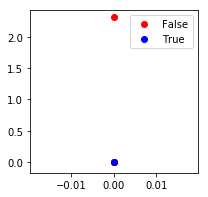

In [7]:
# neural network returning the hidden layer output
def neural_net_hidden(inputs):
    return list(map(lambda x: relu(W[0] @ x + b[0]), inputs))

hidden_out = neural_net_hidden(x)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(hidden_out[0][0], hidden_out[0][1], c='r', label='False')
ax.scatter(hidden_out[1][0], hidden_out[1][1], c='r')
ax.scatter(hidden_out[2][0], hidden_out[2][1], c='b', label='True')
ax.scatter(hidden_out[3][0], hidden_out[3][1], c='b')
legend = ax.legend(loc='best')
plt.show()

In fact, any linear model will be able to find a solution now.

In [8]:
model = LogisticRegression()
model.fit(hidden_out, y)
preds = model.predict(hidden_out)

accuracy_score(y, preds)

1.0